# Numen Medical Adaptation: PubMedQA Benchmark

This notebook demonstrates Numen's performance on the **PubMedQA** dataset, specifically testing its ability to retrieve correct medical abstracts for a given question.

**Key Features:**
- **7-Gram Hashing**: Optimized for long medical terms (e.g., *Hydrochlorothiazide*).
- **32k Dimension**: High-capacity dense vectors to avoid collisions.
- **Training-Free**: No fine-tuning on medical data required.

In [1]:
# Install Dependencies
!pip install -q datasets numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
cudf-polars-cu12 25.6.0 requires pylibcudf-cu12==25.6.*, but you have pylibcudf-cu12 25.2.2 which is incompatible.


In [2]:
import zlib
import numpy as np
import time
from typing import List, Dict, Tuple
from datasets import load_dataset
import matplotlib.pyplot as plt

## Numen Core (Medical Configuration)
Includes 3-7 gram hashing for maximum specificity.

In [3]:
class NumenRetriever:
    """
    Numen-based retrieval system for Medical QA (PubMedQA).
    Uses continuous vector representation with 7-gram hashing.
    """
    
    def __init__(self, codon_size: int = 32768):
        self.codon_size = codon_size
        self.doc_embeddings = {}
        self.doc_ids = []
    
    def encode_to_vector(self, text: str) -> np.ndarray:
        """
        Encode text using Character N-Gram Hashing.
        Optimized for Medical Terminology.
        """
        # 1. Normalize
        text = text.lower()
        
        # 2. Generate character n-grams
        ngrams = []
        words = text.split()
        
        if not words:
            return np.zeros(self.codon_size, dtype=np.float32)
            
        for word in words:
            # Add start/end markers
            word_marked = f"^{word}$"
            
            # Generate 3, 4, 5, 6, 7-grams
            # Medical terms are long (e.g., "Hydrochlorothiazide")
            for n in [3, 4, 5, 6, 7]:
                if len(word_marked) >= n:
                    ngrams.extend([word_marked[i:i+n] for i in range(len(word_marked)-n+1)])
        
        # 3. Hash n-grams into vector space
        vector = np.zeros(self.codon_size, dtype=np.float32)
        
        for gram in ngrams:
            # Deterministic hash
            hash_val = zlib.crc32(gram.encode('utf-8'))
            idx = hash_val % self.codon_size
            
            # Weighted Frequency (TF)
            # Longer n-grams = More Specific = Higher Weight
            length = len(gram)
            if length >= 7:
                weight = 20.0
            elif length == 6:
                weight = 15.0
            elif length == 5:
                weight = 10.0
            elif length == 4:
                weight = 5.0
            else:
                weight = 1.0
            
            vector[idx] += weight
            
        # Apply Log-Saturation (TF Damping)
        vector = np.log1p(vector)
            
        # 4. Normalize
        norm = np.linalg.norm(vector)
        if norm > 0:
            vector = vector / norm
            
        return vector
    
    def index_documents(self, documents: Dict[str, str]):
        """Index all documents."""
        print(f"Indexing {len(documents)} abstracts with dimension {self.codon_size}...")
        start = time.time()
        
        for doc_id, doc_text in documents.items():
            self.doc_embeddings[doc_id] = self.encode_to_vector(doc_text)
            self.doc_ids.append(doc_id)
        
        elapsed = time.time() - start
        print(f"Indexing completed in {elapsed:.2f}s ({len(documents)/elapsed:.1f} docs/sec)")
    
    def search(self, query: str, top_k: int = 100) -> List[Tuple[str, float]]:
        """Search for top-k abstracts."""
        query_vec = self.encode_to_vector(query)
        
        scores = []
        for doc_id in self.doc_ids:
            doc_vec = self.doc_embeddings[doc_id]
            # Cosine similarity
            score = np.dot(query_vec, doc_vec)
            scores.append((doc_id, float(score)))
        
        scores.sort(key=lambda x: x[1], reverse=True)
        return scores[:top_k]

In [4]:
# Load PubMedQA
def load_pubmed_qa():
    print("Loading PubMedQA dataset (BigBio)...")
    try:
        # Load standardized BigBio version (Labeled subset)
        dataset = load_dataset("bigbio/pubmed_qa", "pubmed_qa_labeled_bigbio_qa", split="train")
    except Exception:
        print("Fallback to 'pubmed_qa'...")
        dataset = load_dataset("pubmed_qa", "pqa_labeled", split="train")
    
    documents = {}
    queries = {}
    qrels = {}
    
    for item in dataset:
        # ID handling
        doc_id = str(item.get('pubid', item.get('id', '')))
        if not doc_id: continue
            
        # Abstract handling
        context = item['context']
        if isinstance(context, dict) and 'contexts' in context:
            abstract = " ".join(context['contexts'])
        elif isinstance(context, list):
            abstract = " ".join(context)
        else:
            abstract = str(context)
            
        documents[doc_id] = abstract
        queries[doc_id] = item['question']
        qrels[doc_id] = doc_id
        
    print(f"Loaded {len(documents)} documents and queries.")
    return documents, queries, qrels

documents, queries, qrels = load_pubmed_qa()

Loading PubMedQA dataset (BigBio)...


README.md: 0.00B [00:00, ?B/s]

pubmed_qa.py: 0.00B [00:00, ?B/s]

Fallback to 'pubmed_qa'...


README.md: 0.00B [00:00, ?B/s]

pqa_labeled/train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Loaded 1000 documents and queries.


In [5]:
# Run Benchmark
retriever = NumenRetriever(codon_size=32768)
retriever.index_documents(documents)

k_values = [1, 5, 10, 50, 100]
hits = {k: 0 for k in k_values}

print(f"\nEvaluating on {len(queries)} queries...")
start_time = time.time()

for i, (qid, q_text) in enumerate(queries.items()):
    results = retriever.search(q_text, top_k=max(k_values))
    retrieved_ids = [doc_id for doc_id, _ in results]
    
    target_doc = qrels[qid]
    
    for k in k_values:
        if target_doc in retrieved_ids[:k]:
            hits[k] += 1
            
    if (i+1) % 100 == 0:
        print(f"Processed {i+1}/{len(queries)}...")

elapsed = time.time() - start_time
print(f"Evaluation finished in {elapsed:.2f}s")

print("\nRESULTS:")
for k in k_values:
    accuracy = (hits[k] / len(queries)) * 100
    print(f"Recall@{k} (Accuracy): {accuracy:.2f}%")

Indexing 1000 abstracts with dimension 32768...
Indexing completed in 9.57s (104.5 docs/sec)

Evaluating on 1000 queries...
Processed 100/1000...
Processed 200/1000...
Processed 300/1000...
Processed 400/1000...
Processed 500/1000...
Processed 600/1000...
Processed 700/1000...
Processed 800/1000...
Processed 900/1000...
Processed 1000/1000...
Evaluation finished in 11.97s

RESULTS:
Recall@1 (Accuracy): 93.40%
Recall@5 (Accuracy): 97.70%
Recall@10 (Accuracy): 98.30%
Recall@50 (Accuracy): 99.10%
Recall@100 (Accuracy): 99.30%


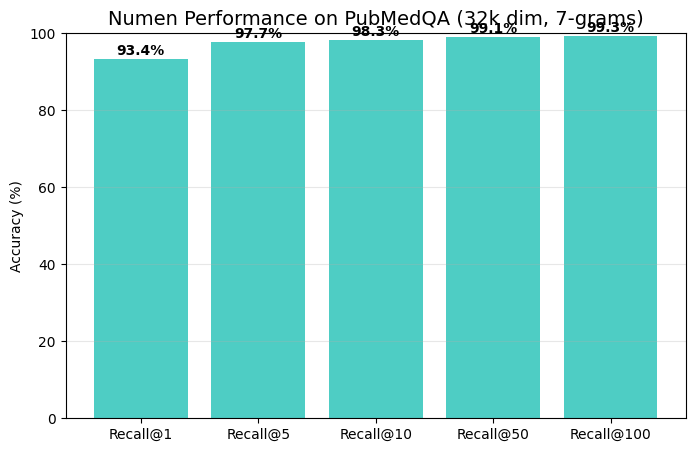

In [6]:
# Visualize
acc_scores = [(hits[k] / len(queries)) * 100 for k in k_values]
plt.figure(figsize=(8, 5))
plt.bar([f"Recall@{k}" for k in k_values], acc_scores, color='#4ecdc4')
plt.title('Numen Performance on PubMedQA (32k dim, 7-grams)', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(acc_scores):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()